# Notebook Setup

In [ ]:
from __future__ import print_function
from google.colab import auth
from google.cloud import bigquery
from google.cloud.bigquery import magics
from IPython.display import display

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import statsmodels.api as sm
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from scipy.stats import sem

In [ ]:
!pip install lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test, logrank_test

In [ ]:
!pip install tableone
from tableone import TableOne, load_dataset

In [ ]:
auth.authenticate_user()

In [ ]:
#@title Fill out this form then press [shift ⇧]+[enter ⏎] {run: "auto"}
import subprocess
import re

analysis_project      = 'mimic-iv-2022bv9'                                  #@param {type:"string"}

admissions_table      = 'physionet-data.mimic_core.admissions'              # @param {type: "string"}
patients_table        = 'physionet-data.mimic_core.patients'                # @param {type: "string"}
diagnoses_icd_table   = 'physionet-data.mimic_hosp.diagnoses_icd'           # @param {type: "string"}
icustays_table        = 'physionet-data.mimic_icu.icustays'                 # @param {type: "string"}
age_table             = 'physionet-data.mimic_derived.age'                  # @param {type: "string"}
first_day_vital_table = 'physionet-data.mimic_derived.first_day_vitalsign'  # @param {type: "string"}
first_day_lab_table   = 'physionet-data.mimic_derived.first_day_lab'        # @param {type: "string"}
first_day_sofa_table  = 'physionet-data.mimic_derived.first_day_sofa'       # @param {type: "string"}
first_day_gcs_table   = 'physionet-data.mimic_derived.first_day_gcs'        # @param {type: "string"}
sapsii_table          = 'physionet-data.mimic_derived.sapsii'               # @param {type: "string"}
icustay_detail_table  = 'physionet-data.mimic_derived.icustay_detail'       # @param {type: "string"}


# Preprocess queries made with the %%bigquery magic
# by substituting these values
sub_dict = {
    'analysis_project':       analysis_project,
    'admissions_table':       admissions_table,
    'patients_table':         patients_table,
    'diagnoses_icd_table':    diagnoses_icd_table ,
    'icustays_table':         icustays_table,
    'age_table':              age_table,
    'first_day_vital_table':  first_day_vital_table,
    'first_day_lab_table':    first_day_lab_table,
    'first_day_sofa_table':   first_day_sofa_table,
    'first_day_gcs_table':    first_day_gcs_table,
    'sapsii_table':           sapsii_table,
    'icustay_detail_table':   icustay_detail_table,
    'ml_table_prefix':        analysis_project + '.MIMIC.models_'
}

# Set the default project for running queries
magics.context.project = analysis_project

In [ ]:
# Set up the substitution preprocessing injection
original_run_query = magics._run_query
def format_and_run_query(client, query, job_config=None):
  query = query.format(**sub_dict)
  #return original_run_query(client, query, job_config)
  return original_run_query(client, query, job_config)

#bigquery.magics._run_query = format_and_run_query
magics._run_query = format_and_run_query

print('analysis_project:', analysis_project)
print()
print('custom %%bigquery magic substitutions:')
for k, v in sub_dict.items():
  print(' ', '{%s}' % k, '→', v)

In [ ]:
%config InlineBackend.figure_format = 'svg'

In [ ]:
bq = bigquery.Client(project=analysis_project)

In [ ]:
if 'MIMIC' not in [d.dataset_id for d in list(bq.list_datasets())]:
  dataset_id = "{}.MIMIC".format(bq.project)
  # Construct a full Dataset object to send to the API.
  # Send the dataset to the API for creation.
  # Raises google.api_core.exceptions.Conflict if the Dataset already
  # exists within the project.

  dataset = bigquery.Dataset(dataset_id)
  dataset = bq.create_dataset(dataset)  # Make an API request.

# Data Population

In [ ]:
%%bigquery
create table MIMIC.Sepsis_Data_Colab as (

-- define sepsis according to Martin criteria and the given ICD-9-CM codes
  with sepsis_group as (
    select subject_id,hadm_id,
    MAX(
          CASE
            WHEN substring(icd_code,1,3) = '038' and icd_version = 9 THEN 1
            WHEN substring(icd_code,1,4) in ('0200','7907','1179','1125') and icd_version = 9 THEN 1
            WHEN substring(icd_code,1,5) = '11281' and icd_version = 9 THEN 1
          ELSE 0 END
        ) AS sepsis
    from `{diagnoses_icd_table}`
    group by subject_id, hadm_id
  )

  select subject_id, hadm_id, stay_id
  from `{icustays_table}` 
  inner join sepsis_group using (subject_id, hadm_id)
  inner join `{age_table}` using (subject_id, hadm_id)
  inner join `{first_day_vital_table}` using (subject_id, stay_id)
  inner join `{first_day_lab_table}` using (subject_id, stay_id)
  inner join `{first_day_sofa_table}` using (subject_id, hadm_id, stay_id)

  where subject_id is not null and hadm_id is not null and stay_id is not null

  -- INCLUSION

  -- sepsis
  and sepsis = 1

  -- more than 24 hours in the icu

  and date_diff(outtime, intime, second) > 24*60*60 

  -- patients >= 18 or <= 89
  and age >= 18 and age <= 89

  -- EXCLUSION

  -- sofa score < 2 according to sepsis 3.0 definition
  and  SOFA >= 2

  -- patients without blood platelets data
  and platelets_min is not null

  -- patients without vital signs
  and heart_rate_mean is not null 
  and sbp_mean is not null 
  and dbp_mean is not null 
  and mbp_mean is not null 
  and resp_rate_mean is not null 
  and temperature_mean is not null

  -- Get all patient ids
  group by subject_id, hadm_id, stay_id
)

In [ ]:
%%bigquery population
select * from MIMIC.Sepsis_Data_Colab

In [ ]:
print(f"Population size: {len(population['subject_id'].unique())} patients")

Population size: 4702 patients


# Feature Extraction

In [ ]:
%%bigquery df_features
-- get baseline variables - age, gender, ethnicity, admission_type and rank each icu_stay in order to choose the first one
with first_icu_general as (
select subject_id, hadm_id, stay_id, admission_age as age, gender, icd.ethnicity, adm.admission_type, ROW_NUMBER() OVER(PARTITION BY subject_id order by icu_intime) as rank 
from `mimic-iv-2022bv9.MIMIC.Sepsis_Data_Colab`  sdc
INNER JOIN `{icustay_detail_table}` icd using(subject_id, hadm_id, stay_id)
INNER JOIN `{admissions_table}` adm using(subject_id, hadm_id)
where subject_id is not null and stay_id is not null
),

-- get vital signs - hr, sbp, dbp, mbp, spo2, rr, t
first_icu_vital_signs as (
  select subject_id, stay_id, heart_rate_mean as HR, sbp_mean as SBP, dbp_mean as DBP, mbp_mean as MBP, spo2_mean as SpO2, resp_rate_mean as RR, temperature_mean AS T
  from `{first_day_vital_table}` 
  inner join first_icu_general using(subject_id, stay_id)
  where subject_id is not null and stay_id is not null
),

-- get laboratoray params - creatinine, glucose, hemoglobin, etc.
first_icu_lab_paramas as (
  select subject_id, stay_id, creatinine_max as Cr, glucose_min AS Glucose_min, glucose_max AS Glucose_max,
  hemoglobin_min as Hemoglobin, platelets_min as Platelets, ptt_max as PTT, 
  inr_max AS INR, pt_max AS PT, bun_max AS BUN, wbc_max AS WBC, potassium_min AS Potassium_min, 
  potassium_max as Potassium_max, sodium_min as Sodium_min, sodium_max as Sodium_max

  from `{first_day_lab_table}` 
  inner join first_icu_general using(subject_id, stay_id)
  where subject_id is not null and stay_id is not null
),

-- get sofa score for the first 24 hours at the icu
first_icu_sofa_score as (
  select subject_id, stay_id, SOFA
  from `{first_day_sofa_table}` 
  inner join first_icu_general using(subject_id, stay_id)
  where subject_id is not null and stay_id is not null
),

-- get gcs score for the first 24 hours at the icu
first_icu_gcs_score as (
  select subject_id, stay_id, gcs_min as GCS
  from `{first_day_gcs_table}` 
  inner join first_icu_general using(subject_id, stay_id)
  where subject_id is not null and stay_id is not null
),

-- get sapsii score for the first 24 hours at the icu
first_icu_sapsii_score as (
  select subject_id, stay_id, SAPSII
  from `{sapsii_table}`
  inner join first_icu_general using(subject_id, stay_id)
  where subject_id is not null and stay_id is not null
),

-- get outcomes
first_icu_outcomes as (
  select subject_id, stay_id, los_hospital,
  (CASE
    WHEN DATE_DIFF(dod, admittime, day) <= 365 THEN 1
    ELSE 0 END 
  ) AS One_year_survival_bin,
  (CASE 
    WHEN DATE_DIFF(dod, admittime, day) <= 365 THEN DATE_DIFF(dod, admittime, day)
    ELSE NULL END
  ) AS One_year_survival_con, 
  hospital_expire_flag as in_hospital_mortality  
  from `{icustay_detail_table}` 
  inner join first_icu_general using(subject_id, stay_id)
  where subject_id is not null and stay_id is not null
)

select subject_id, stay_id, 
Age, Gender, Ethnicity, Admission_type, 
HR, SBP, DBP, MBP, SpO2, RR, T, Cr, 
Hemoglobin, Platelets, PTT, INR, PT, BUN, WBC, Potassium_min, Potassium_max, Sodium_min, Sodium_max, Glucose_min, Glucose_max, 
SOFA, GCS, SAPSII, 
Los_hospital, One_year_survival_bin, One_year_survival_con, In_hospital_mortality

from first_icu_general 
inner join first_icu_vital_signs using(subject_id ,stay_id)
inner join first_icu_lab_paramas using(subject_id ,stay_id)
inner join first_icu_sofa_score using(subject_id ,stay_id)
inner join first_icu_gcs_score using(subject_id ,stay_id)
inner join first_icu_sapsii_score using(subject_id ,stay_id)
inner join first_icu_outcomes using(subject_id ,stay_id)
where subject_id is not null and stay_id is not null and rank = 1
order by stay_id



In [ ]:
display(df_features.head())

,subject_id,stay_id,Age,Gender,Ethnicity,Admission_type,HR,SBP,DBP,MBP,...,Sodium_max,Glucose_min,Glucose_max,SOFA,GCS,SAPSII,Los_hospital,One_year_survival_bin,One_year_survival_con,In_hospital_mortality
0,16513856,30001446,56,M,WHITE,EW EMER.,75.916667,98.090909,54.045455,69.480000,...,132.0,75.0,94.0,12,14.0,38,6,0,NaN,0
1,15332791,30003598,64,F,WHITE,EW EMER.,82.114286,117.243243,55.216216,76.378378,...,137.0,131.0,160.0,5,14.0,49,57,0,NaN,0
2,10332722,30005362,80,M,WHITE,EW EMER.,105.080000,97.043478,51.000000,61.304348,...,138.0,81.0,122.0,10,3.0,56,19,1,19.0,1
3,14569364,30005707,83,M,WHITE,EW EMER.,91.583333,97.368421,53.500000,66.736842,...,141.0,111.0,127.0,10,11.0,58,14,0,NaN,0
4,18756985,30006983,77,M,ASIAN,ELECTIVE,87.280000,111.521739,61.652174,78.434783,...,142.0,48.0,93.0,17,4.0,58,42,1,42.0,1


# Baseline patient characteristics and outcomes

In [ ]:
df_features_only = df_features[df_features.columns.difference(['One_year_survival_con'])]
print(f"Pateints with missing data: {df_features_only.shape[0] - df_features_only.dropna().shape[0]}")

Pateints with missing data: 359


In [ ]:
# fill nan values accordig to the paper using mean value

have_nan = df_features.isna().sum().sum() != 0

print(f"Is data has nan values? {have_nan}")

if have_nan == True:

  display(df_features.isna().sum())
  
  print()
  print("Filling nan values with mean values...")
  
  nan_cols = [i for i in df_features.columns if df_features[i].isnull().any() and i != 'One_year_survival_con']
  df_features[nan_cols] = df_features[nan_cols].fillna(value = df_features[nan_cols].mean())
  display(df_features.isna().sum())
  

Is data has nan values? True


subject_id                  0
stay_id                     0
Age                         0
Gender                      0
Ethnicity                   0
Admission_type              0
HR                          0
SBP                         0
DBP                         0
MBP                         0
SpO2                        4
RR                          0
T                           0
Cr                          1
Hemoglobin                  1
Platelets                   0
PTT                       341
INR                       311
PT                        311
BUN                         3
WBC                         1
Potassium_min               2
Potassium_max               2
Sodium_min                  2
Sodium_max                  2
Glucose_min                 7
Glucose_max                 7
SOFA                        0
GCS                         0
SAPSII                      0
Los_hospital                0
One_year_survival_bin       0
One_year_survival_con    3348
In_hospita


Filling nan values with mean values...


subject_id                  0
stay_id                     0
Age                         0
Gender                      0
Ethnicity                   0
Admission_type              0
HR                          0
SBP                         0
DBP                         0
MBP                         0
SpO2                        0
RR                          0
T                           0
Cr                          0
Hemoglobin                  0
Platelets                   0
PTT                         0
INR                         0
PT                          0
BUN                         0
WBC                         0
Potassium_min               0
Potassium_max               0
Sodium_min                  0
Sodium_max                  0
Glucose_min                 0
Glucose_max                 0
SOFA                        0
GCS                         0
SAPSII                      0
Los_hospital                0
One_year_survival_bin       0
One_year_survival_con    3348
In_hospita

In [ ]:
# define for each patient its platelet group
def set_platelet_group(p):
  if p is not None:
    if p < 100:
      return 'thrombocytopenia'
    elif 100 <= p <= 300:
      return 'normal'
    else:
      return 'thrombocytosis'
  return p

df_features["platelet_group"] = df_features['Platelets'].apply(set_platelet_group)

In [ ]:
display(df_features["platelet_group"].value_counts())

normal              2892
thrombocytopenia    1047
thrombocytosis       763
Name: platelet_group, dtype: int64

In [ ]:
# prepare data for tableone printing

columns     = ['Age', 'Gender', 'Ethnicity', 'Admission_type',
               'HR', 'SBP', 'DBP', 'MBP', 'SpO2', 'RR', 'T', 'Cr',
               'Glucose_min','Hemoglobin', 'Platelets', 'PTT', 'INR', 'PT', 'BUN', 'WBC', 'Potassium_min', 
               'Potassium_max', 'Sodium_min', 'Sodium_max', 
               'SAPSII', 'SOFA', 'GCS',  
               'Los_hospital', 'One_year_survival_con', 'One_year_survival_bin', 'In_hospital_mortality']

categorical = ['Gender', 'Ethnicity', 'Admission_type',
               'In_hospital_mortality', 'One_year_survival_bin']

nonnormal    = ['Age', 'HR', 'SBP', 'DBP', 'MBP', 'SpO2', 'RR', 'T', 'Cr', 
                'Glucose_min', 'Hemoglobin','Platelets', 'PTT', 'INR', 'PT', 'BUN', 'WBC', 'Potassium_min', 'Potassium_max', 'Sodium_min', 'Sodium_max', 
                'SAPSII', 'SOFA', 'GCS', 
                'Los_hospital', 'One_year_survival_con']

groupby     = ['platelet_group']

In [ ]:
table = TableOne(df_features, columns=columns, categorical=categorical, groupby=groupby,
                  nonnormal=nonnormal, missing=False, pval=True, overall=False, htest_name=True, )

display(table)

/usr/local/lib/python3.7/dist-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),


Grouped by platelet_group                                                                                             
                                                                                       normal     thrombocytopenia       thrombocytosis P-Value                                       Test
n                                                                                        2892                 1047                  763                                                   
Age, median [Q1,Q3]                                                          68.0 [57.0,79.0]     61.0 [52.0,73.0]     67.0 [56.0,77.0]  <0.001                             Kruskal-Wallis
Gender, n (%)                         F                                           1236 (42.7)           453 (43.3)           361 (47.3)   0.074                                Chi-squared
                                      M                                           1656 (57.3)           594 (56.7)           402 (52.7)                                                   
Ethnicity, n (%)                      AMERICAN INDIAN/ALASKA NATIVE                   5 (0.2)              6 (0.6)                        0.196  Chi-squared (warning: expected count < 5)
                                      ASIAN                                         100 (3.5)             37 (3.5)             19 (2.5)                                                   
                                      BLACK/AFRICAN AMERICAN                       304 (10.5)             98 (9.4)            79 (10.4)                                                   
                                      HISPANIC/LATINO                               108 (3.7)             49 (4.7)             21 (2.8)                                                   
                                      OTHER                                         128 (4.4)             52 (5.0)             33 (4.3)                                                   
                                      UNABLE TO OBTAIN                               42 (1.5)             20 (1.9)             14 (1.8)                                                   
                                      UNKNOWN                                       199 (6.9)             78 (7.4)             61 (8.0)                                                   
                                      WHITE                                       2006 (69.4)           707 (67.5)           536 (70.2)                                                   
Admission_type, n (%)                 DIRECT EMER.                                   76 (2.6)             83 (7.9)             19 (2.5)  <0.001  Chi-squared (warning: expected count < 5)
                                      DIRECT OBSERVATION                              1 (0.0)                                                                                             
                                      ELECTIVE                                       24 (0.8)             16 (1.5)              5 (0.7)                                                   
                                      EU OBSERVATION                                  1 (0.0)                                                                                             
                                      EW EMER.                                    2127 (73.5)           671 (64.1)           540 (70.8)                                                   
                                      OBSERVATION ADMIT                               7 (0.2)              3 (0.3)              1 (0.1)                                                   
                                      SURGICAL SAME DAY ADMISSION                    56 (1.9)             17 (1.6)             16 (2.1)                                                   
                                      URGENT                                       600 (20.7)           257 (24.5)           182 (23.9)      

# Survival Analysis

In [ ]:
# fill nan survival values with 365 (one year)
df_copy = df_features.copy()
df_copy['One_year_survival_con'] = df_copy['One_year_survival_con'].fillna(365)

# drop unique columns
df_copy.drop(labels=['subject_id', 'stay_id'], axis = 1, inplace = True)

In [ ]:
# init Kaplan Meier Fitter
kmf_normal = KaplanMeierFitter()
kmf_abnormal = KaplanMeierFitter()

# split data into normal and abnormal platelets
normal = df_copy[df_copy["platelet_group"] == "normal"]
abnormal = df_copy[df_copy["platelet_group"] != "normal"]

In [ ]:
# fit kaplan meier to mimic iv data
kmf_normal.fit(durations = normal["One_year_survival_con"], event_observed = normal["One_year_survival_bin"], label = "Normal platelet group")
kmf_abnormal.fit(durations = abnormal["One_year_survival_con"], event_observed = abnormal["One_year_survival_bin"], label = "Abnormal platelet group")

<lifelines.KaplanMeierFitter:"Abnormal platelet group", fitted with 1810 total observations, 1157 right-censored observations>

In [ ]:
# calculate the logrank test value
T = normal["One_year_survival_con"]
E = normal["One_year_survival_bin"]

T1 = abnormal["One_year_survival_con"]
E1 = abnormal["One_year_survival_bin"]

results = logrank_test(T, T1, event_observed_A = E, event_observed_B = E1)
log_rank_p = "p < 0.005" if results.p_value < 0.005 else f"p = {round(results.p_value, 3)}"
_text = f"Log-rank test, {log_rank_p}"

Text(0.5, 0.6, 'Log-rank test, p < 0.005')

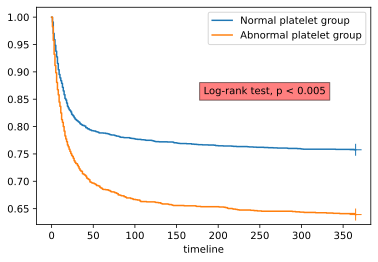

In [ ]:
# plot Kaplan Meier graph with logrank test value
ax = kmf_normal.plot_survival_function(show_censors=True, ci_show = False)
kmf_abnormal.plot_survival_function(show_censors=True, ci_show = False)

ax.text(0.5, 0.6, _text, transform=ax.transAxes, bbox=dict(facecolor='red', alpha=0.5))

In [ ]:
display(kmf_normal.survival_function_)

,Normal platelet group
timeline,
0.0,0.999654
1.0,0.991010
2.0,0.970263
3.0,0.958852
4.0,0.948479
...,...
302.0,0.758645
341.0,0.758299
363.0,0.757953


In [ ]:
display(kmf_abnormal.survival_function_)

,Abnormal platelet group
timeline,
0.0,1.000000
1.0,0.982320
2.0,0.957459
3.0,0.932044
4.0,0.911602
...,...
330.0,0.641989
338.0,0.641436
346.0,0.640884


Cox proportional hazard

In [ ]:
# transform gender to binary
le_gender = LabelEncoder()
df_copy['Gender'] = le_gender.fit_transform(df_features['Gender'])

In [ ]:
# one hot encoding for categorical variables 
df_copy = pd.get_dummies(df_copy, columns = ['platelet_group', 'Ethnicity', 'Admission_type'], prefix = ['plat', 'eth', 'adm'], drop_first = False)
display(df_copy)

,Age,Gender,HR,SBP,DBP,MBP,SpO2,RR,T,Cr,...,eth_UNKNOWN,eth_WHITE,adm_DIRECT EMER.,adm_DIRECT OBSERVATION,adm_ELECTIVE,adm_EU OBSERVATION,adm_EW EMER.,adm_OBSERVATION ADMIT,adm_SURGICAL SAME DAY ADMISSION,adm_URGENT
0,56,1,75.916667,98.090909,54.045455,69.480000,98.791667,20.333333,36.220000,2.9,...,0,1,0,0,0,0,1,0,0,0
1,64,0,82.114286,117.243243,55.216216,76.378378,99.838710,20.323529,36.463750,1.8,...,0,1,0,0,0,0,1,0,0,0
2,80,1,105.080000,97.043478,51.000000,61.304348,95.500000,28.160000,36.721429,2.9,...,0,1,0,0,0,0,1,0,0,0
3,83,1,91.583333,97.368421,53.500000,66.736842,98.708333,19.140000,37.412857,3.6,...,0,1,0,0,0,0,1,0,0,0
4,77,1,87.280000,111.521739,61.652174,78.434783,96.583333,19.250000,36.294286,1.4,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4697,28,1,101.296296,101.560000,47.920000,60.520000,96.320000,22.296296,35.824000,1.7,...,0,1,0,0,0,0,0,0,0,1
4698,69,1,85.440000,104.296296,45.814815,68.982143,97.800000,18.653846,37.110000,1.8,...,0,1,0,0,0,0,1,0,0,0
4699,87,1,73.807692,115.208333,51.166667,67.480000,96.846154,21.653846,37.097143,0.9,...,0,1,1,0,0,0,0,0,0,0
4700,40,0,109.375000,95.000000,36.720000,52.520000,100.000000,17.138889,37.901818,3.3,...,0,1,0,0,0,0,1,0,0,0


In [ ]:
# use plat_normal as baseline (reference)
features = ['Age', 'Gender', 'Cr', 'BUN', 'Glucose_min', 'Hemoglobin', 'plat_thrombocytopenia', 'plat_thrombocytosis',
            'INR', 'PTT', 'PT', 'WBC', 'Sodium_min', 'Sodium_max', 'Potassium_min', 'Potassium_max',
            # add risk scores
            "SAPSII", "SOFA", "GCS",
            'One_year_survival_con', 'One_year_survival_bin'
            ]

In [ ]:
# compute the significance of this classification on survival using multivariate analysis Cox Proportional-Hazards Model
data = df_copy[features]
cph = CoxPHFitter()
cph.fit(data, 'One_year_survival_con', event_col = 'One_year_survival_bin')
# cph.print_summary()
cph.print_summary(columns = ['coef', 'coef lower 95%',	'coef upper 95%',	'z',	'p',	'-log2(p)'])

<lifelines.CoxPHFitter: fitted with 4702 total observations, 3348 right-censored observations>
             duration col = 'One_year_survival_con'
                event col = 'One_year_survival_bin'
      baseline estimation = breslow
   number of observations = 4702
number of events observed = 1354
   partial log-likelihood = -10746.19
         time fit was run = 2022-08-03 15:02:28 UTC

---
                        coef   coef lower 95%   coef upper 95%     z      p   -log2(p)
covariate                                                                             
Age                     0.01             0.01             0.02  5.49 <0.005      24.59
Gender                 -0.09            -0.20             0.02 -1.67   0.10       3.39
Cr                     -0.06            -0.10            -0.02 -3.16 <0.005       9.31
BUN                     0.00            -0.00             0.00  1.71   0.09       3.53
Glucose_min            -0.00            -0.00             0.00 -1.54   0.12       3.02
Hemoglobin             -0.04            -0.07            -0.01 -2.76   0.01       7.42
plat_thrombocytopenia   0.39             0.25             0.52  5.42 <0.005      24.00
plat_thrombocytosis     0.22             0.07             0.38  2.82 <0.005       7.71
INR                     0.02            -0.07             0.11  0.39   0.70       0.52
PTT                     0.00             0.00             0.01  5.42 <0.005      24.02
PT                      0.01            -0.00             0.01  1.14   0.25       1.99
WBC                     0.00            -0.00             0.01  1.23   0.22       2.21
Sodium_min              0.02             0.00             0.04  2.05   0.04       4.62
Sodium_max             -0.03            -0.05            -0.01 -3.20 <0.005       9.48
Potassium_min           0.24             0.13             0.35  4.28 <0.005      15.68
Potassium_max           0.00            -0.08             0.08  0.07   0.94       0.09
SAPSII                  0.02             0.02             0.03  8.72 <0.005      58.32
SOFA                    0.06             0.04             0.08  6.07 <0.005      29.52
GCS                    -0.04            -0.06            -0.03 -5.09 <0.005      21.45
---
Concordance = 0.74
Partial AIC = 21530.38
log-likelihood ratio test = 972.24 on 19 df
-log2(p) of ll-ratio test = 642.30

# One-Year Overall Survival

In [ ]:
# get table 2 features but add risk scores
table2_features = ["Age", "Gender", "Cr", "BUN", "Glucose_min", "Hemoglobin", "plat_normal", "plat_thrombocytopenia", "plat_thrombocytosis",
                   "INR", "PTT", "PT", "WBC", "Sodium_min", "Sodium_max", "Potassium_min", "Potassium_max",
                   # add risk scores
                   "SAPSII", "SOFA", "GCS"
                   ]

In [ ]:
def print_results(model):
  """
  This function calculates the p-value, the odds ratio and 95% confidence interval
  """
  p_value = round(model.pvalues, 3)
  odds_ratio = round(np.exp(model.params), 3)
  confidence_interval = round(np.exp(model.conf_int()), 3)

  confidence_interval["Odds Ratio"] = odds_ratio
  confidence_interval["P value"] = p_value
  confidence_interval.columns = ['[0.025', '0.975]', 'Odds Ratio', 'P-value']

  return confidence_interval

Univariate Analysis

In [ ]:
# using logistic regression for each variable from the list table2_features to predict the 1-year survival binary variable
y_train = df_copy['One_year_survival_bin']
results = []

for v in table2_features:
  X_train = df_copy[v]
  model = sm.Logit(y_train, X_train).fit(disp=0)
  res = print_results(model)
  results.append(res)

display(pd.concat(results))

,[0.025,0.975],Odds Ratio,P-value
Age,0.987,0.989,0.988,0.0
Gender,0.360,0.426,0.391,0.0
Cr,0.779,0.820,0.799,0.0
BUN,0.987,0.990,0.988,0.0
Glucose_min,0.992,0.993,0.993,0.0
Hemoglobin,0.903,0.915,0.909,0.0
plat_normal,0.294,0.348,0.320,0.0
plat_thrombocytopenia,0.639,0.816,0.722,0.0
plat_thrombocytosis,0.333,0.456,0.390,0.0
INR,0.743,0.788,0.765,0.0


Multivariate Analysis

In [ ]:
# Use multivariable logistic regression, to compute the same statistics for each variable
X_train = df_copy[table2_features]
y_train = df_copy['One_year_survival_bin']

log_reg_multi = sm.Logit(y_train, X_train).fit(disp=0)
print("With risk scores")
print_results(log_reg_multi)

With risk scores


,[0.025,0.975],Odds Ratio,P-value
Age,1.008,1.019,1.013,0.000
Gender,0.780,1.043,0.902,0.164
Cr,0.864,0.959,0.910,0.000
BUN,1.001,1.008,1.004,0.020
Glucose_min,0.998,1.001,0.999,0.357
Hemoglobin,0.888,0.957,0.922,0.000
plat_normal,0.094,5.872,0.742,0.777
plat_thrombocytopenia,0.161,9.934,1.264,0.824
plat_thrombocytosis,0.120,7.511,0.949,0.961
INR,0.897,1.196,1.036,0.633


In [ ]:
X_train = df_copy[[v for v in table2_features if v not in ['SAPSII', 'SOFA', 'GCS']]]
y_train = df_copy['One_year_survival_bin']

log_reg_multi = sm.Logit(y_train, X_train).fit(disp=0)
print("WithOUT risk scores")
print_results(log_reg_multi)

WithOUT risk scores


,[0.025,0.975],Odds Ratio,P-value
Age,1.013,1.023,1.018,0.000
Gender,0.749,0.985,0.859,0.030
Cr,0.889,0.975,0.931,0.002
BUN,1.007,1.013,1.010,0.000
Glucose_min,0.998,1.001,0.999,0.324
Hemoglobin,0.898,0.963,0.930,0.000
plat_thrombocytopenia,1.900,2.634,2.237,0.000
plat_thrombocytosis,0.917,1.340,1.108,0.289
INR,0.936,1.240,1.077,0.299
PTT,1.006,1.011,1.009,0.000


Multivariate Model Discrimination

Optimization terminated successfully.
         Current function value: 0.555448
         Iterations 6


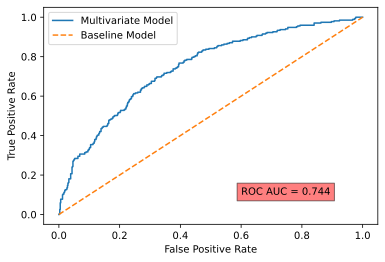

In [ ]:
# Compute ROC AUC of the multivariable logistic regression on a test set
X = df_copy[[v for v in table2_features if v not in ['SAPSII', 'SOFA', 'GCS']]]
y = df_copy['One_year_survival_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 210)

lr_model = sm.Logit(y_train, X_train).fit()

y_pred = lr_model.predict(X_test)
fpr, tpr, _  = roc_curve(y_test,  y_pred)
baseline = np.linspace(0, 1, 10)
auc = round(roc_auc_score(y_test, y_pred),3)

# plot the ROC curve
plt.plot(fpr, tpr)
plt.plot(baseline, baseline, '--')
plt.text(0.6,0.1, f"ROC AUC = {auc}",  bbox=dict(facecolor='red', alpha=0.5))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(labels = ['Multivariate Model', 'Baseline Model'])
plt.show()

In [ ]:
# calcualte confidence interaval
n_bootstraps = 1000
rng_seed = 42  # control reproducibility
bootstrapped_scores = []

y_true = y_test.reset_index(drop= True)
y_pred_ = y_pred.reset_index(drop= True)

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_), len(y_pred_))
    if len(np.unique(y_true[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_true[indices], y_pred_[indices])
    bootstrapped_scores.append(score)

In [ ]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 95% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.708 - 0.778]


Multivariate Model Calibration

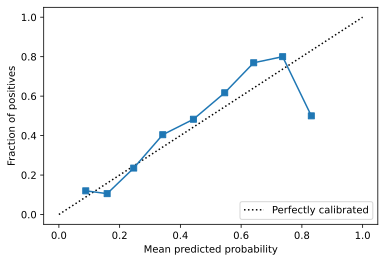

In [ ]:
# Test the calibration of the logistic model on the test set
prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)
disp = CalibrationDisplay(prob_true, prob_pred, y_pred)
disp.plot()